# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

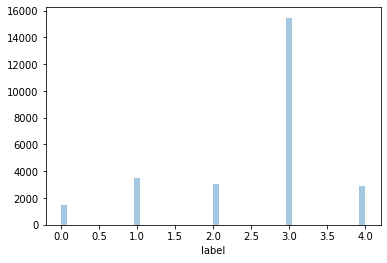

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "vit_base_patch16_384"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 24
    gradient_accumulation_steps = 1
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 2567
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

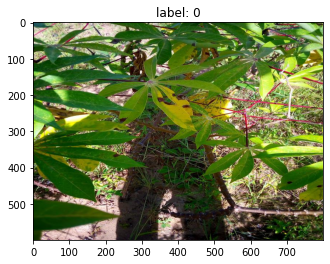

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

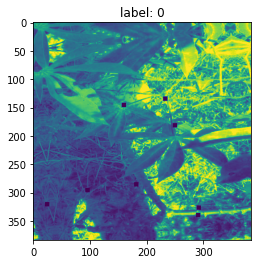

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [26]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0920,  0.6792, -0.7813,  0.2777, -0.1530],
        [-0.2099,  0.1616,  0.6402,  0.0728,  0.8263],
        [ 0.1250, -0.1980,  0.9257,  0.0663,  0.5926],
        [-0.3386,  0.5822, -0.6300,  0.1845, -0.1813]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


Epoch: [1][0/877] Elapsed 0m 7s (remain 112m 59s) Loss: 0.5115(0.5115) Grad: 1.1568 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 25s (remain 10m 53s) Loss: 0.1939(0.2800) Grad: 0.6300 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 41s (remain 9m 4s) Loss: 0.1159(0.2239) Grad: 0.5943 LR: 0.000100  
Epoch: [1][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.0842(0.1942) Grad: 0.7528 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 15s (remain 6m 14s) Loss: 0.1740(0.1793) Grad: 0.8224 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 32s (remain 4m 54s) Loss: 0.1667(0.1693) Grad: 0.8487 LR: 0.000099  
Epoch: [1][600/877] Elapsed 7m 49s (remain 3m 35s) Loss: 0.1757(0.1610) Grad: 0.7752 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 6s (remain 2m 17s) Loss: 0.0944(0.1544) Grad: 0.5117 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.0580(0.1497) Grad: 0.5244 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 21s (remain 0m 0s) Loss: 0.0262(0.1478) Grad: 0.4075 LR: 0.000098  
E

Epoch 1 - avg_train_loss: 0.1478  avg_val_loss: 0.1048  time: 747s
Epoch 1 - Accuracy: 0.8857251328777525
Epoch 1 - Save Best Score: 0.8857 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0607(0.1048) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 24m 30s) Loss: 0.0472(0.0472) Grad: 0.4147 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 18s (remain 10m 0s) Loss: 0.0444(0.0951) Grad: 0.8154 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 34s (remain 8m 39s) Loss: 0.0188(0.0852) Grad: 0.3652 LR: 0.000096  
Epoch: [2][300/877] Elapsed 3m 51s (remain 7m 22s) Loss: 0.0335(0.0854) Grad: 0.6263 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 7s (remain 6m 4s) Loss: 0.0582(0.0855) Grad: 0.4688 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 23s (remain 4m 48s) Loss: 0.1295(0.0851) Grad: 0.8278 LR: 0.000094  
Epoch: [2][600/877] Elapsed 7m 40s (remain 3m 31s) Loss: 0.1181(0.0857) Grad: 0.6161 LR: 0.000093  
Epoch: [2][700/877] Elapsed 8m 56s (remain 2m 14s) Loss: 0.1412(0.0855) Grad: 0.8908 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 12s (remain 0m 58s) Loss: 0.0237(0.0846) Grad: 0.5487 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 11s 

Epoch 2 - avg_train_loss: 0.0843  avg_val_loss: 0.1077  time: 736s
Epoch 2 - Accuracy: 0.8826879271070615


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1457(0.1077) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 25m 53s) Loss: 0.4210(0.4210) Grad: 0.8669 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 19s (remain 10m 12s) Loss: 0.2647(0.2310) Grad: 0.5116 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 37s (remain 8m 49s) Loss: 0.3011(0.2176) Grad: 0.6671 LR: 0.000088  
Epoch: [3][300/877] Elapsed 3m 55s (remain 7m 29s) Loss: 0.2106(0.2202) Grad: 0.7453 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 12s (remain 6m 11s) Loss: 0.2059(0.2191) Grad: 0.7870 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 30s (remain 4m 52s) Loss: 0.1870(0.2182) Grad: 0.4552 LR: 0.000085  
Epoch: [3][600/877] Elapsed 7m 48s (remain 3m 34s) Loss: 0.1290(0.2177) Grad: 0.7782 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 5s (remain 2m 16s) Loss: 0.3419(0.2167) Grad: 0.6156 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 22s (remain 0m 59s) Loss: 0.2400(0.2156) Grad: 0.5010 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 22

Epoch 3 - avg_train_loss: 0.2149  avg_val_loss: 0.1120  time: 747s
Epoch 3 - Accuracy: 0.8766135155656796


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1155(0.1120) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 25m 34s) Loss: 0.1193(0.1193) Grad: 0.5201 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 19s (remain 10m 10s) Loss: 0.3147(0.1984) Grad: 0.5848 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 37s (remain 8m 48s) Loss: 0.1263(0.2010) Grad: 0.5123 LR: 0.000077  
Epoch: [4][300/877] Elapsed 3m 55s (remain 7m 29s) Loss: 0.2080(0.2045) Grad: 0.5646 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 12s (remain 6m 11s) Loss: 0.1999(0.2015) Grad: 0.6202 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 30s (remain 4m 52s) Loss: 0.1613(0.2020) Grad: 0.4960 LR: 0.000072  
Epoch: [4][600/877] Elapsed 7m 48s (remain 3m 34s) Loss: 0.0689(0.1988) Grad: 0.5719 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 5s (remain 2m 16s) Loss: 0.2356(0.1975) Grad: 0.5409 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.1511(0.1982) Grad: 0.6263 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 22

Epoch 4 - avg_train_loss: 0.1987  avg_val_loss: 0.1086  time: 748s
Epoch 4 - Accuracy: 0.8794608959757023


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1345(0.1086) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 27m 10s) Loss: 0.1599(0.1599) Grad: 0.6325 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 19s (remain 10m 9s) Loss: 0.1861(0.1882) Grad: 0.5835 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 36s (remain 8m 47s) Loss: 0.1800(0.1853) Grad: 0.3422 LR: 0.000063  
Epoch: [5][300/877] Elapsed 3m 54s (remain 7m 28s) Loss: 0.1120(0.1845) Grad: 0.6896 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 12s (remain 6m 10s) Loss: 0.1895(0.1890) Grad: 0.5668 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 29s (remain 4m 52s) Loss: 0.2035(0.1897) Grad: 0.3561 LR: 0.000058  
Epoch: [5][600/877] Elapsed 7m 47s (remain 3m 34s) Loss: 0.2364(0.1909) Grad: 0.4888 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 5s (remain 2m 16s) Loss: 0.1448(0.1891) Grad: 0.8544 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.1000(0.1892) Grad: 0.5649 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 22s

Epoch 5 - avg_train_loss: 0.1902  avg_val_loss: 0.1054  time: 747s
Epoch 5 - Accuracy: 0.8838268792710706


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1008(0.1054) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 25m 53s) Loss: 0.0829(0.0829) Grad: 0.6400 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 19s (remain 10m 10s) Loss: 0.1899(0.1783) Grad: 0.3191 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 36s (remain 8m 47s) Loss: 0.0706(0.1907) Grad: 0.6469 LR: 0.000048  
Epoch: [6][300/877] Elapsed 3m 54s (remain 7m 29s) Loss: 0.0718(0.1899) Grad: 0.2887 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 13s (remain 6m 11s) Loss: 0.1347(0.1927) Grad: 0.4681 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 30s (remain 4m 53s) Loss: 0.1626(0.1943) Grad: 0.4189 LR: 0.000042  
Epoch: [6][600/877] Elapsed 7m 48s (remain 3m 34s) Loss: 0.4451(0.1932) Grad: 1.0107 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 5s (remain 2m 17s) Loss: 0.1888(0.1935) Grad: 0.4425 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.3269(0.1925) Grad: 0.6166 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 22

Epoch 6 - avg_train_loss: 0.1925  avg_val_loss: 0.1030  time: 747s
Epoch 6 - Accuracy: 0.8849658314350797


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0681(0.1030) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 27m 23s) Loss: 0.1127(0.1127) Grad: 0.6541 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 18s (remain 10m 6s) Loss: 0.2022(0.1274) Grad: 0.5058 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 35s (remain 8m 44s) Loss: 0.1767(0.1349) Grad: 0.6122 LR: 0.000033  
Epoch: [7][300/877] Elapsed 3m 52s (remain 7m 25s) Loss: 0.1883(0.1343) Grad: 0.4680 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 9s (remain 6m 7s) Loss: 0.0717(0.1323) Grad: 0.4982 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 26s (remain 4m 50s) Loss: 0.0730(0.1327) Grad: 0.6680 LR: 0.000028  
Epoch: [7][600/877] Elapsed 7m 43s (remain 3m 33s) Loss: 0.1320(0.1353) Grad: 0.6971 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 0s (remain 2m 15s) Loss: 0.0561(0.1373) Grad: 0.7665 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 17s (remain 0m 58s) Loss: 0.0893(0.1384) Grad: 0.4966 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 16s (

Epoch 7 - avg_train_loss: 0.1374  avg_val_loss: 0.1008  time: 742s
Epoch 7 - Accuracy: 0.8878132118451025
Epoch 7 - Save Best Score: 0.8878 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0350(0.1008) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 28m 1s) Loss: 0.1078(0.1078) Grad: 0.6252 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 19s (remain 10m 7s) Loss: 0.1545(0.1420) Grad: 0.5093 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 36s (remain 8m 44s) Loss: 0.1218(0.1342) Grad: 0.8909 LR: 0.000019  
Epoch: [8][300/877] Elapsed 3m 52s (remain 7m 25s) Loss: 0.0477(0.1382) Grad: 0.5254 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 10s (remain 6m 8s) Loss: 0.0235(0.1408) Grad: 0.4545 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 27s (remain 4m 50s) Loss: 0.1723(0.1398) Grad: 0.6589 LR: 0.000016  
Epoch: [8][600/877] Elapsed 7m 43s (remain 3m 33s) Loss: 0.2860(0.1371) Grad: 0.4446 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 0s (remain 2m 15s) Loss: 0.1663(0.1380) Grad: 0.6970 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 18s (remain 0m 58s) Loss: 0.0642(0.1376) Grad: 0.7439 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 16s (

Epoch 8 - avg_train_loss: 0.1390  avg_val_loss: 0.1005  time: 742s
Epoch 8 - Accuracy: 0.8870539104024298


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0425(0.1005) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 28m 2s) Loss: 0.0600(0.0600) Grad: 0.6452 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 18s (remain 10m 6s) Loss: 0.0355(0.1284) Grad: 0.2871 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 35s (remain 8m 43s) Loss: 0.2346(0.1268) Grad: 0.4415 LR: 0.000009  
Epoch: [9][300/877] Elapsed 3m 52s (remain 7m 25s) Loss: 0.1305(0.1294) Grad: 0.5853 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 9s (remain 6m 7s) Loss: 0.0757(0.1303) Grad: 0.4770 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 26s (remain 4m 50s) Loss: 0.2365(0.1321) Grad: 0.5306 LR: 0.000007  
Epoch: [9][600/877] Elapsed 7m 43s (remain 3m 32s) Loss: 0.0541(0.1326) Grad: 0.8316 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 0s (remain 2m 15s) Loss: 0.1954(0.1346) Grad: 0.4110 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 17s (remain 0m 58s) Loss: 0.2519(0.1356) Grad: 0.7405 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 16s (r

Epoch 9 - avg_train_loss: 0.1352  avg_val_loss: 0.1011  time: 741s
Epoch 9 - Accuracy: 0.8864844343204252


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0448(0.1011) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 21m 51s) Loss: 0.1453(0.1453) Grad: 0.5095 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 17s (remain 9m 58s) Loss: 0.0167(0.0614) Grad: 0.3575 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 34s (remain 8m 38s) Loss: 0.0581(0.0577) Grad: 0.5831 LR: 0.000003  
Epoch: [10][300/877] Elapsed 3m 50s (remain 7m 21s) Loss: 0.0179(0.0578) Grad: 0.2723 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 7s (remain 6m 4s) Loss: 0.0520(0.0562) Grad: 0.4780 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 23s (remain 4m 48s) Loss: 0.1265(0.0565) Grad: 0.5133 LR: 0.000002  
Epoch: [10][600/877] Elapsed 7m 40s (remain 3m 31s) Loss: 0.0140(0.0563) Grad: 0.3265 LR: 0.000002  
Epoch: [10][700/877] Elapsed 8m 56s (remain 2m 14s) Loss: 0.0645(0.0567) Grad: 0.4238 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 13s (remain 0m 58s) Loss: 0.0202(0.0568) Grad: 0.4918 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0569  avg_val_loss: 0.1007  time: 736s
Epoch 10 - Accuracy: 0.8889521640091116
Epoch 10 - Save Best Score: 0.8890 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0250(0.1007) 


Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.88895
========== fold: 1 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 24m 31s) Loss: 0.4971(0.4971) Grad: 1.3454 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 19s (remain 10m 9s) Loss: 0.1215(0.2800) Grad: 0.5457 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 37s (remain 8m 48s) Loss: 0.2311(0.2244) Grad: 0.8984 LR: 0.000100  
Epoch: [1][300/877] Elapsed 3m 54s (remain 7m 29s) Loss: 0.2052(0.1961) Grad: 0.6672 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 12s (remain 6m 11s) Loss: 0.0474(0.1812) Grad: 0.6192 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 30s (remain 4m 52s) Loss: 0.1264(0.1701) Grad: 0.6942 LR: 0.000099  
Epoch: [1][600/877] Elapsed 7m 47s (remain 3m 34s) Loss: 0.1741(0.1622) Grad: 0.8299 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 5s (remain 2m 17s) Loss: 0.1466(0.1567) Grad: 0.8340 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.1453(0.1516) Grad: 0.6619 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 22s (remain 0m 0s) Loss: 0.1699(0.1476) Grad: 0.7463 LR: 0.000098  
EV

Epoch 1 - avg_train_loss: 0.1476  avg_val_loss: 0.1138  time: 747s
Epoch 1 - Accuracy: 0.876044039483675
Epoch 1 - Save Best Score: 0.8760 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0976(0.1138) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 24m 8s) Loss: 0.0365(0.0365) Grad: 0.5307 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 19s (remain 10m 9s) Loss: 0.0443(0.0873) Grad: 0.7141 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 37s (remain 8m 48s) Loss: 0.0475(0.0836) Grad: 0.7269 LR: 0.000096  
Epoch: [2][300/877] Elapsed 3m 54s (remain 7m 29s) Loss: 0.0515(0.0836) Grad: 0.4209 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 12s (remain 6m 10s) Loss: 0.0784(0.0854) Grad: 0.7893 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 30s (remain 4m 52s) Loss: 0.0372(0.0844) Grad: 0.7678 LR: 0.000094  
Epoch: [2][600/877] Elapsed 7m 47s (remain 3m 34s) Loss: 0.1718(0.0875) Grad: 0.8509 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 5s (remain 2m 16s) Loss: 0.0640(0.0869) Grad: 0.2712 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.0974(0.0868) Grad: 0.7003 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 22s 

Epoch 2 - avg_train_loss: 0.0865  avg_val_loss: 0.1008  time: 747s
Epoch 2 - Accuracy: 0.8910402429764617
Epoch 2 - Save Best Score: 0.8910 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1307(0.1008) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 26m 40s) Loss: 0.3468(0.3468) Grad: 1.3532 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 21s (remain 10m 23s) Loss: 0.2848(0.2394) Grad: 0.5520 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 40s (remain 8m 58s) Loss: 0.1894(0.2258) Grad: 0.5558 LR: 0.000088  
Epoch: [3][300/877] Elapsed 3m 58s (remain 7m 37s) Loss: 0.2655(0.2212) Grad: 0.6598 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 18s (remain 6m 17s) Loss: 0.0721(0.2180) Grad: 0.4578 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.1879(0.2177) Grad: 0.7307 LR: 0.000085  
Epoch: [3][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.0659(0.2136) Grad: 0.4244 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.2515(0.2120) Grad: 0.5038 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.0570(0.2109) Grad: 0.4146 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 33

Epoch 3 - avg_train_loss: 0.2114  avg_val_loss: 0.1089  time: 759s
Epoch 3 - Accuracy: 0.884206529992407


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0975(0.1089) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 26m 37s) Loss: 0.0949(0.0949) Grad: 0.5461 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 20s (remain 10m 20s) Loss: 0.2688(0.1922) Grad: 0.3835 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 39s (remain 8m 57s) Loss: 0.1480(0.1910) Grad: 0.8071 LR: 0.000077  
Epoch: [4][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.3611(0.1944) Grad: 0.8033 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.2363(0.1940) Grad: 0.5115 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.2924(0.1942) Grad: 0.5770 LR: 0.000072  
Epoch: [4][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.3102(0.1960) Grad: 0.4495 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 13s (remain 2m 18s) Loss: 0.2700(0.1973) Grad: 0.5327 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 32s (remain 1m 0s) Loss: 0.1381(0.1987) Grad: 0.6211 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 32

Epoch 4 - avg_train_loss: 0.1982  avg_val_loss: 0.1030  time: 758s
Epoch 4 - Accuracy: 0.8946469248291572
Epoch 4 - Save Best Score: 0.8946 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1432(0.1030) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 25m 52s) Loss: 0.1793(0.1793) Grad: 0.7675 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 20s (remain 10m 18s) Loss: 0.1203(0.1970) Grad: 0.4538 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 39s (remain 8m 55s) Loss: 0.0800(0.1890) Grad: 0.6806 LR: 0.000063  
Epoch: [5][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.1516(0.1952) Grad: 0.4717 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.1748(0.1951) Grad: 1.0199 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 35s (remain 4m 56s) Loss: 0.3328(0.1931) Grad: 0.4733 LR: 0.000058  
Epoch: [5][600/877] Elapsed 7m 54s (remain 3m 37s) Loss: 0.1721(0.1942) Grad: 0.5425 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 13s (remain 2m 18s) Loss: 0.1661(0.1939) Grad: 0.5714 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 32s (remain 0m 59s) Loss: 0.1313(0.1935) Grad: 0.6309 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 3

Epoch 5 - avg_train_loss: 0.1927  avg_val_loss: 0.1020  time: 757s
Epoch 5 - Accuracy: 0.8889521640091116


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1364(0.1020) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 25m 55s) Loss: 0.2624(0.2624) Grad: 0.5124 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 20s (remain 10m 19s) Loss: 0.1813(0.1928) Grad: 0.3962 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 40s (remain 8m 58s) Loss: 0.3006(0.1859) Grad: 0.5672 LR: 0.000048  
Epoch: [6][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.1016(0.1894) Grad: 0.4696 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.1204(0.1899) Grad: 0.6555 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.0518(0.1896) Grad: 0.5998 LR: 0.000042  
Epoch: [6][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.1972(0.1893) Grad: 0.5093 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.1026(0.1927) Grad: 0.6589 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.1838(0.1923) Grad: 0.6510 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 33

Epoch 6 - avg_train_loss: 0.1917  avg_val_loss: 0.1033  time: 759s
Epoch 6 - Accuracy: 0.8889521640091116


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1689(0.1033) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 26m 17s) Loss: 0.2144(0.2144) Grad: 0.3030 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 20s (remain 10m 16s) Loss: 0.1771(0.1497) Grad: 0.3788 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 38s (remain 8m 53s) Loss: 0.1340(0.1444) Grad: 0.7053 LR: 0.000033  
Epoch: [7][300/877] Elapsed 3m 56s (remain 7m 33s) Loss: 0.1681(0.1450) Grad: 0.6243 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 15s (remain 6m 14s) Loss: 0.2583(0.1433) Grad: 0.5423 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 33s (remain 4m 55s) Loss: 0.1131(0.1426) Grad: 0.5471 LR: 0.000028  
Epoch: [7][600/877] Elapsed 7m 51s (remain 3m 36s) Loss: 0.3993(0.1416) Grad: 0.4783 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 9s (remain 2m 18s) Loss: 0.1009(0.1415) Grad: 0.5111 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 27s (remain 0m 59s) Loss: 0.2406(0.1401) Grad: 0.3153 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 27

Epoch 7 - avg_train_loss: 0.1383  avg_val_loss: 0.0959  time: 752s
Epoch 7 - Accuracy: 0.8940774487471527


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1669(0.0959) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 26m 25s) Loss: 0.0699(0.0699) Grad: 0.6892 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 20s (remain 10m 17s) Loss: 0.1288(0.1386) Grad: 0.7169 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 38s (remain 8m 53s) Loss: 0.3063(0.1396) Grad: 0.4876 LR: 0.000019  
Epoch: [8][300/877] Elapsed 3m 56s (remain 7m 33s) Loss: 0.1883(0.1430) Grad: 0.8229 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 15s (remain 6m 14s) Loss: 0.0596(0.1418) Grad: 0.4502 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 33s (remain 4m 55s) Loss: 0.1089(0.1400) Grad: 0.6703 LR: 0.000016  
Epoch: [8][600/877] Elapsed 7m 51s (remain 3m 36s) Loss: 0.3274(0.1416) Grad: 0.6820 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 10s (remain 2m 18s) Loss: 0.2515(0.1407) Grad: 0.3414 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 28s (remain 0m 59s) Loss: 0.1478(0.1405) Grad: 0.3508 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 2

Epoch 8 - avg_train_loss: 0.1416  avg_val_loss: 0.0962  time: 753s
Epoch 8 - Accuracy: 0.8952164009111617
Epoch 8 - Save Best Score: 0.8952 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1572(0.0962) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 26m 40s) Loss: 0.0919(0.0919) Grad: 0.8122 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 20s (remain 10m 15s) Loss: 0.1337(0.1441) Grad: 0.8063 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 38s (remain 8m 52s) Loss: 0.2517(0.1425) Grad: 0.4264 LR: 0.000009  
Epoch: [9][300/877] Elapsed 3m 56s (remain 7m 33s) Loss: 0.1002(0.1368) Grad: 0.8195 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 14s (remain 6m 13s) Loss: 0.1306(0.1314) Grad: 0.8507 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 33s (remain 4m 54s) Loss: 0.1907(0.1337) Grad: 0.4870 LR: 0.000007  
Epoch: [9][600/877] Elapsed 7m 51s (remain 3m 36s) Loss: 0.0678(0.1329) Grad: 0.6713 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 9s (remain 2m 17s) Loss: 0.0944(0.1318) Grad: 0.5331 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 27s (remain 0m 59s) Loss: 0.2421(0.1302) Grad: 0.4411 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 26

Epoch 9 - avg_train_loss: 0.1296  avg_val_loss: 0.0954  time: 752s
Epoch 9 - Accuracy: 0.8976841305998481
Epoch 9 - Save Best Score: 0.8977 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1661(0.0954) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 22m 46s) Loss: 0.0691(0.0691) Grad: 0.7508 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 19s (remain 10m 8s) Loss: 0.0372(0.0697) Grad: 0.5694 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 37s (remain 8m 48s) Loss: 0.1004(0.0656) Grad: 0.8219 LR: 0.000003  
Epoch: [10][300/877] Elapsed 3m 54s (remain 7m 29s) Loss: 0.0459(0.0631) Grad: 0.3132 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 12s (remain 6m 10s) Loss: 0.1173(0.0623) Grad: 0.7050 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 30s (remain 4m 52s) Loss: 0.0449(0.0615) Grad: 0.5870 LR: 0.000002  
Epoch: [10][600/877] Elapsed 7m 47s (remain 3m 34s) Loss: 0.0879(0.0604) Grad: 0.8242 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 5s (remain 2m 16s) Loss: 0.0418(0.0599) Grad: 0.3423 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 23s (remain 0m 59s) Loss: 0.0472(0.0587) Grad: 0.3136 LR: 0.000002  
Epoch: [10][876/877] Elaps

Epoch 10 - avg_train_loss: 0.0585  avg_val_loss: 0.0933  time: 748s
Epoch 10 - Accuracy: 0.89749430523918
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1188(0.0933) 


========== fold: 1 result ==========
Score: 0.89768
========== fold: 2 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 25m 13s) Loss: 0.5225(0.5225) Grad: 1.1875 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 20s (remain 10m 18s) Loss: 0.2103(0.2863) Grad: 0.6523 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 39s (remain 8m 56s) Loss: 0.1814(0.2215) Grad: 0.5761 LR: 0.000100  
Epoch: [1][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.0881(0.1958) Grad: 0.8659 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.2310(0.1788) Grad: 1.0148 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.0284(0.1670) Grad: 0.5747 LR: 0.000099  
Epoch: [1][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.1626(0.1610) Grad: 0.9427 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.1036(0.1541) Grad: 0.4669 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.1175(0.1493) Grad: 0.4892 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 33s (remain 0m 0s) Loss: 0.1106(0.1464) Grad: 0.6800 LR: 0.000098  
E

Epoch 1 - avg_train_loss: 0.1464  avg_val_loss: 0.1055  time: 758s
Epoch 1 - Accuracy: 0.8839946838807671
Epoch 1 - Save Best Score: 0.8840 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2855(0.1055) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 22m 55s) Loss: 0.0486(0.0486) Grad: 0.3949 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 20s (remain 10m 18s) Loss: 0.0630(0.0801) Grad: 0.5732 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 39s (remain 8m 56s) Loss: 0.1398(0.0838) Grad: 0.6115 LR: 0.000096  
Epoch: [2][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.0200(0.0889) Grad: 0.4467 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.0461(0.0871) Grad: 0.6220 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.0567(0.0874) Grad: 0.7708 LR: 0.000094  
Epoch: [2][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.0549(0.0877) Grad: 0.6900 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.0160(0.0866) Grad: 0.4225 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.0865(0.0865) Grad: 0.8711 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 33

Epoch 2 - avg_train_loss: 0.0860  avg_val_loss: 0.1078  time: 758s
Epoch 2 - Accuracy: 0.8849439908866528
Epoch 2 - Save Best Score: 0.8849 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1619(0.1078) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 27m 45s) Loss: 0.4246(0.4246) Grad: 1.1720 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 21s (remain 10m 27s) Loss: 0.1546(0.2269) Grad: 0.9161 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 41s (remain 9m 3s) Loss: 0.1698(0.2118) Grad: 0.9830 LR: 0.000088  
Epoch: [3][300/877] Elapsed 4m 2s (remain 7m 43s) Loss: 0.2581(0.2087) Grad: 0.6068 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 22s (remain 6m 22s) Loss: 0.2562(0.2087) Grad: 0.4335 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 41s (remain 5m 1s) Loss: 0.2749(0.2094) Grad: 0.5184 LR: 0.000085  
Epoch: [3][600/877] Elapsed 8m 1s (remain 3m 41s) Loss: 0.2892(0.2082) Grad: 0.4682 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 21s (remain 2m 20s) Loss: 0.2614(0.2083) Grad: 0.6581 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 41s (remain 1m 0s) Loss: 0.1865(0.2084) Grad: 0.8905 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 42s (r

Epoch 3 - avg_train_loss: 0.2069  avg_val_loss: 0.1102  time: 767s
Epoch 3 - Accuracy: 0.8826656540725271


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2121(0.1102) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 27m 56s) Loss: 0.1317(0.1317) Grad: 0.7300 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 22s (remain 10m 32s) Loss: 0.1750(0.1995) Grad: 0.4060 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 42s (remain 9m 5s) Loss: 0.2960(0.1996) Grad: 0.5302 LR: 0.000077  
Epoch: [4][300/877] Elapsed 4m 2s (remain 7m 43s) Loss: 0.2067(0.2034) Grad: 0.4412 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 22s (remain 6m 23s) Loss: 0.3183(0.2011) Grad: 0.5206 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 42s (remain 5m 1s) Loss: 0.3233(0.2015) Grad: 0.6577 LR: 0.000072  
Epoch: [4][600/877] Elapsed 8m 2s (remain 3m 41s) Loss: 0.2158(0.2005) Grad: 0.6639 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 22s (remain 2m 21s) Loss: 0.0998(0.2005) Grad: 0.8039 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 42s (remain 1m 0s) Loss: 0.1254(0.2007) Grad: 0.6870 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 43s (r

Epoch 4 - avg_train_loss: 0.2006  avg_val_loss: 0.1022  time: 769s
Epoch 4 - Accuracy: 0.8906398329219669
Epoch 4 - Save Best Score: 0.8906 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2409(0.1022) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 27m 2s) Loss: 0.1454(0.1454) Grad: 0.3628 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 21s (remain 10m 30s) Loss: 0.1557(0.1962) Grad: 0.4956 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 41s (remain 9m 4s) Loss: 0.2499(0.1924) Grad: 0.4103 LR: 0.000063  
Epoch: [5][300/877] Elapsed 4m 1s (remain 7m 42s) Loss: 0.3339(0.1918) Grad: 0.5742 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 21s (remain 6m 22s) Loss: 0.0669(0.1961) Grad: 0.3523 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 41s (remain 5m 1s) Loss: 0.1136(0.1933) Grad: 0.4267 LR: 0.000058  
Epoch: [5][600/877] Elapsed 8m 1s (remain 3m 41s) Loss: 0.2417(0.1919) Grad: 0.4184 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 21s (remain 2m 21s) Loss: 0.0832(0.1933) Grad: 0.4189 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 41s (remain 1m 0s) Loss: 0.0752(0.1938) Grad: 0.3419 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 42s (re

Epoch 5 - avg_train_loss: 0.1926  avg_val_loss: 0.1061  time: 768s
Epoch 5 - Accuracy: 0.8828555154737042


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2518(0.1061) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 27m 47s) Loss: 0.2546(0.2546) Grad: 0.4591 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 22s (remain 10m 31s) Loss: 0.1621(0.1930) Grad: 1.2492 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 42s (remain 9m 7s) Loss: 0.1797(0.1848) Grad: 0.5302 LR: 0.000048  
Epoch: [6][300/877] Elapsed 4m 2s (remain 7m 44s) Loss: 0.1588(0.1885) Grad: 0.6214 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 23s (remain 6m 23s) Loss: 0.2013(0.1895) Grad: 0.5132 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 43s (remain 5m 2s) Loss: 0.2684(0.1895) Grad: 0.6160 LR: 0.000042  
Epoch: [6][600/877] Elapsed 8m 3s (remain 3m 41s) Loss: 0.2914(0.1885) Grad: 0.4611 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 23s (remain 2m 21s) Loss: 0.1578(0.1904) Grad: 0.5604 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 43s (remain 1m 1s) Loss: 0.1727(0.1902) Grad: 0.6539 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 44s (r

Epoch 6 - avg_train_loss: 0.1909  avg_val_loss: 0.1026  time: 770s
Epoch 6 - Accuracy: 0.8870324662996013


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2342(0.1026) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 27m 26s) Loss: 0.1880(0.1880) Grad: 0.8634 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 21s (remain 10m 26s) Loss: 0.0610(0.1523) Grad: 0.3584 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 40s (remain 9m 0s) Loss: 0.0928(0.1503) Grad: 0.5634 LR: 0.000033  
Epoch: [7][300/877] Elapsed 4m 0s (remain 7m 40s) Loss: 0.2766(0.1494) Grad: 0.7395 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 20s (remain 6m 20s) Loss: 0.0440(0.1476) Grad: 0.4593 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 39s (remain 5m 0s) Loss: 0.2997(0.1470) Grad: 0.6510 LR: 0.000028  
Epoch: [7][600/877] Elapsed 7m 59s (remain 3m 40s) Loss: 0.0646(0.1463) Grad: 0.7341 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 18s (remain 2m 20s) Loss: 0.1364(0.1478) Grad: 1.1161 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 37s (remain 1m 0s) Loss: 0.0350(0.1478) Grad: 0.3902 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 38s (

Epoch 7 - avg_train_loss: 0.1470  avg_val_loss: 0.1016  time: 763s
Epoch 7 - Accuracy: 0.8881716347066642


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2563(0.1016) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 27m 35s) Loss: 0.1970(0.1970) Grad: 0.3718 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 21s (remain 10m 26s) Loss: 0.1301(0.1500) Grad: 0.7791 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 41s (remain 9m 1s) Loss: 0.2434(0.1359) Grad: 0.4830 LR: 0.000019  
Epoch: [8][300/877] Elapsed 4m 0s (remain 7m 40s) Loss: 0.1593(0.1377) Grad: 0.5033 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 20s (remain 6m 20s) Loss: 0.0402(0.1373) Grad: 0.3799 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 39s (remain 5m 0s) Loss: 0.2642(0.1388) Grad: 0.6361 LR: 0.000016  
Epoch: [8][600/877] Elapsed 7m 59s (remain 3m 40s) Loss: 0.2265(0.1376) Grad: 0.3277 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 18s (remain 2m 20s) Loss: 0.2276(0.1367) Grad: 0.4725 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 37s (remain 1m 0s) Loss: 0.1021(0.1351) Grad: 0.5274 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 38s (

Epoch 8 - avg_train_loss: 0.1359  avg_val_loss: 0.1007  time: 763s
Epoch 8 - Accuracy: 0.889310803113727


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.2104(0.1007) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 27m 23s) Loss: 0.2498(0.2498) Grad: 0.3552 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 21s (remain 10m 25s) Loss: 0.0435(0.1401) Grad: 0.4853 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 40s (remain 9m 0s) Loss: 0.2090(0.1422) Grad: 0.6901 LR: 0.000009  
Epoch: [9][300/877] Elapsed 4m 0s (remain 7m 39s) Loss: 0.2117(0.1386) Grad: 0.4193 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 19s (remain 6m 19s) Loss: 0.0998(0.1417) Grad: 0.6788 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 39s (remain 4m 59s) Loss: 0.1213(0.1410) Grad: 0.7791 LR: 0.000007  
Epoch: [9][600/877] Elapsed 7m 58s (remain 3m 39s) Loss: 0.2717(0.1408) Grad: 0.5864 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 17s (remain 2m 20s) Loss: 0.1236(0.1399) Grad: 0.8384 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 37s (remain 1m 0s) Loss: 0.0636(0.1388) Grad: 0.7816 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 37s 

Epoch 9 - avg_train_loss: 0.1376  avg_val_loss: 0.0992  time: 763s
Epoch 9 - Accuracy: 0.8929181697360926
Epoch 9 - Save Best Score: 0.8929 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.2039(0.0992) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 22m 50s) Loss: 0.0921(0.0921) Grad: 0.7436 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 20s (remain 10m 18s) Loss: 0.0717(0.0709) Grad: 0.6860 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 39s (remain 8m 55s) Loss: 0.0453(0.0678) Grad: 0.6984 LR: 0.000003  
Epoch: [10][300/877] Elapsed 3m 58s (remain 7m 36s) Loss: 0.0465(0.0628) Grad: 0.6686 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 17s (remain 6m 16s) Loss: 0.1168(0.0610) Grad: 0.8377 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 36s (remain 4m 57s) Loss: 0.1871(0.0605) Grad: 0.7689 LR: 0.000002  
Epoch: [10][600/877] Elapsed 7m 55s (remain 3m 38s) Loss: 0.0760(0.0604) Grad: 0.5223 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 14s (remain 2m 19s) Loss: 0.1193(0.0597) Grad: 0.7072 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 33s (remain 1m 0s) Loss: 0.1656(0.0602) Grad: 0.9073 LR: 0.000002  
Epoch: [10][876/877] Elap

Epoch 10 - avg_train_loss: 0.0598  avg_val_loss: 0.0987  time: 759s
Epoch 10 - Accuracy: 0.8889310803113727
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.2216(0.0987) 


========== fold: 2 result ==========
Score: 0.89292
========== fold: 3 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 25m 57s) Loss: 0.4986(0.4986) Grad: 1.0233 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 21s (remain 10m 28s) Loss: 0.1791(0.2796) Grad: 0.8548 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 41s (remain 9m 4s) Loss: 0.2164(0.2201) Grad: 0.5583 LR: 0.000100  
Epoch: [1][300/877] Elapsed 4m 1s (remain 7m 42s) Loss: 0.0690(0.1925) Grad: 0.6181 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 21s (remain 6m 21s) Loss: 0.0693(0.1793) Grad: 0.9148 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 41s (remain 5m 1s) Loss: 0.1303(0.1677) Grad: 0.8942 LR: 0.000099  
Epoch: [1][600/877] Elapsed 8m 1s (remain 3m 41s) Loss: 0.0507(0.1593) Grad: 0.4043 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 21s (remain 2m 21s) Loss: 0.1574(0.1537) Grad: 0.8481 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 41s (remain 1m 0s) Loss: 0.1121(0.1498) Grad: 0.6057 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 42s (remain 0m 0s) Loss: 0.0727(0.1476) Grad: 0.6576 LR: 0.000098  
EVAL:

Epoch 1 - avg_train_loss: 0.1476  avg_val_loss: 0.1050  time: 768s
Epoch 1 - Accuracy: 0.8847541294854756
Epoch 1 - Save Best Score: 0.8848 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.2645(0.1050) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 22m 58s) Loss: 0.1884(0.1884) Grad: 0.4896 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 21s (remain 10m 28s) Loss: 0.0695(0.0852) Grad: 0.5863 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 41s (remain 9m 4s) Loss: 0.1289(0.0833) Grad: 0.6839 LR: 0.000096  
Epoch: [2][300/877] Elapsed 4m 1s (remain 7m 42s) Loss: 0.0912(0.0871) Grad: 0.4063 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 21s (remain 6m 21s) Loss: 0.0699(0.0847) Grad: 0.5308 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 41s (remain 5m 1s) Loss: 0.0720(0.0839) Grad: 0.9441 LR: 0.000094  
Epoch: [2][600/877] Elapsed 8m 1s (remain 3m 41s) Loss: 0.0452(0.0850) Grad: 0.6060 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 21s (remain 2m 21s) Loss: 0.0876(0.0858) Grad: 0.2749 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 41s (remain 1m 0s) Loss: 0.1446(0.0856) Grad: 0.8742 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 42s (r

Epoch 2 - avg_train_loss: 0.0858  avg_val_loss: 0.1036  time: 767s
Epoch 2 - Accuracy: 0.8872223277007785
Epoch 2 - Save Best Score: 0.8872 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.2325(0.1036) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 27m 20s) Loss: 0.2371(0.2371) Grad: 0.8256 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 23s (remain 10m 40s) Loss: 0.3170(0.2258) Grad: 0.7287 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 44s (remain 9m 14s) Loss: 0.1583(0.2193) Grad: 0.5616 LR: 0.000088  
Epoch: [3][300/877] Elapsed 4m 6s (remain 7m 50s) Loss: 0.2076(0.2183) Grad: 0.7684 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 27s (remain 6m 28s) Loss: 0.2718(0.2189) Grad: 0.4796 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 48s (remain 5m 6s) Loss: 0.1054(0.2152) Grad: 0.6213 LR: 0.000085  
Epoch: [3][600/877] Elapsed 8m 9s (remain 3m 44s) Loss: 0.1483(0.2170) Grad: 0.7177 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 30s (remain 2m 23s) Loss: 0.2796(0.2170) Grad: 0.6343 LR: 0.000082  
Epoch: [3][800/877] Elapsed 10m 51s (remain 1m 1s) Loss: 0.0802(0.2141) Grad: 0.6974 LR: 0.000081  
Epoch: [3][876/877] Elapsed 11m 53s (

Epoch 3 - avg_train_loss: 0.2140  avg_val_loss: 0.1107  time: 779s
Epoch 3 - Accuracy: 0.8836149610784128


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.2221(0.1107) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 26m 11s) Loss: 0.3675(0.3675) Grad: 0.7995 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 23s (remain 10m 37s) Loss: 0.1535(0.1993) Grad: 0.9408 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 43s (remain 9m 10s) Loss: 0.2101(0.1931) Grad: 0.4658 LR: 0.000077  
Epoch: [4][300/877] Elapsed 4m 4s (remain 7m 47s) Loss: 0.1512(0.1931) Grad: 0.8547 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 25s (remain 6m 26s) Loss: 0.3312(0.1951) Grad: 0.3748 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 46s (remain 5m 5s) Loss: 0.0647(0.1976) Grad: 0.6776 LR: 0.000072  
Epoch: [4][600/877] Elapsed 8m 8s (remain 3m 44s) Loss: 0.1999(0.1967) Grad: 0.5018 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 29s (remain 2m 23s) Loss: 0.1963(0.1976) Grad: 0.6174 LR: 0.000069  
Epoch: [4][800/877] Elapsed 10m 50s (remain 1m 1s) Loss: 0.2967(0.1972) Grad: 1.0174 LR: 0.000067  
Epoch: [4][876/877] Elapsed 11m 52s (

Epoch 4 - avg_train_loss: 0.1972  avg_val_loss: 0.1041  time: 778s
Epoch 4 - Accuracy: 0.8936776153408013
Epoch 4 - Save Best Score: 0.8937 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1833(0.1041) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 27m 38s) Loss: 0.1912(0.1912) Grad: 0.3826 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 23s (remain 10m 40s) Loss: 0.2919(0.1804) Grad: 0.5047 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 44s (remain 9m 12s) Loss: 0.1232(0.1818) Grad: 0.5900 LR: 0.000063  
Epoch: [5][300/877] Elapsed 4m 5s (remain 7m 49s) Loss: 0.1443(0.1845) Grad: 0.6181 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 26s (remain 6m 27s) Loss: 0.2175(0.1871) Grad: 0.3625 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 47s (remain 5m 5s) Loss: 0.3073(0.1923) Grad: 0.4856 LR: 0.000058  
Epoch: [5][600/877] Elapsed 8m 8s (remain 3m 44s) Loss: 0.1240(0.1901) Grad: 0.4748 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 29s (remain 2m 22s) Loss: 0.2856(0.1888) Grad: 0.4196 LR: 0.000054  
Epoch: [5][800/877] Elapsed 10m 50s (remain 1m 1s) Loss: 0.2957(0.1886) Grad: 0.4213 LR: 0.000052  
Epoch: [5][876/877] Elapsed 11m 52s (

Epoch 5 - avg_train_loss: 0.1894  avg_val_loss: 0.1030  time: 778s
Epoch 5 - Accuracy: 0.8931080311372698


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1577(0.1030) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 26m 59s) Loss: 0.2629(0.2629) Grad: 0.4875 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 23s (remain 10m 37s) Loss: 0.2959(0.1903) Grad: 0.5627 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 43s (remain 9m 11s) Loss: 0.2434(0.1905) Grad: 0.4534 LR: 0.000048  
Epoch: [6][300/877] Elapsed 4m 5s (remain 7m 49s) Loss: 0.2549(0.1896) Grad: 0.4551 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 26s (remain 6m 27s) Loss: 0.0657(0.1899) Grad: 0.7117 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 47s (remain 5m 5s) Loss: 0.2121(0.1892) Grad: 0.4594 LR: 0.000042  
Epoch: [6][600/877] Elapsed 8m 8s (remain 3m 44s) Loss: 0.0743(0.1877) Grad: 0.7304 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 29s (remain 2m 23s) Loss: 0.0894(0.1868) Grad: 0.6102 LR: 0.000039  
Epoch: [6][800/877] Elapsed 10m 50s (remain 1m 1s) Loss: 0.1864(0.1875) Grad: 0.4060 LR: 0.000037  
Epoch: [6][876/877] Elapsed 11m 52s (

Epoch 6 - avg_train_loss: 0.1873  avg_val_loss: 0.0975  time: 777s
Epoch 6 - Accuracy: 0.8984241503702297
Epoch 6 - Save Best Score: 0.8984 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1636(0.0975) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 27m 46s) Loss: 0.0636(0.0636) Grad: 0.5220 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 22s (remain 10m 33s) Loss: 0.1202(0.1287) Grad: 0.6152 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 43s (remain 9m 9s) Loss: 0.0620(0.1430) Grad: 0.6564 LR: 0.000033  
Epoch: [7][300/877] Elapsed 4m 3s (remain 7m 46s) Loss: 0.1183(0.1403) Grad: 0.6991 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 24s (remain 6m 24s) Loss: 0.1034(0.1409) Grad: 0.8953 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 45s (remain 5m 3s) Loss: 0.0936(0.1424) Grad: 0.4042 LR: 0.000028  
Epoch: [7][600/877] Elapsed 8m 5s (remain 3m 43s) Loss: 0.1464(0.1421) Grad: 1.0136 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 26s (remain 2m 22s) Loss: 0.0723(0.1419) Grad: 0.5173 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 46s (remain 1m 1s) Loss: 0.1133(0.1413) Grad: 0.6027 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 48s (r

Epoch 7 - avg_train_loss: 0.1413  avg_val_loss: 0.0958  time: 773s
Epoch 7 - Accuracy: 0.8969052591608127


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.1439(0.0958) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 27m 18s) Loss: 0.1592(0.1592) Grad: 0.7136 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 22s (remain 10m 32s) Loss: 0.1270(0.1169) Grad: 0.8363 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 42s (remain 9m 7s) Loss: 0.3022(0.1254) Grad: 0.7382 LR: 0.000019  
Epoch: [8][300/877] Elapsed 4m 3s (remain 7m 46s) Loss: 0.2857(0.1365) Grad: 0.4443 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 24s (remain 6m 24s) Loss: 0.1813(0.1410) Grad: 0.3954 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 44s (remain 5m 3s) Loss: 0.0304(0.1418) Grad: 0.6297 LR: 0.000016  
Epoch: [8][600/877] Elapsed 8m 5s (remain 3m 42s) Loss: 0.2117(0.1399) Grad: 0.6686 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 26s (remain 2m 22s) Loss: 0.1897(0.1394) Grad: 0.5868 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 46s (remain 1m 1s) Loss: 0.0836(0.1388) Grad: 0.6694 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 48s (r

Epoch 8 - avg_train_loss: 0.1403  avg_val_loss: 0.0950  time: 773s
Epoch 8 - Accuracy: 0.898803873172584
Epoch 8 - Save Best Score: 0.8988 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1495(0.0950) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 27m 7s) Loss: 0.1175(0.1175) Grad: 0.4347 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 22s (remain 10m 32s) Loss: 0.0656(0.1324) Grad: 0.9868 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 42s (remain 9m 7s) Loss: 0.0498(0.1361) Grad: 0.7365 LR: 0.000009  
Epoch: [9][300/877] Elapsed 4m 3s (remain 7m 45s) Loss: 0.0392(0.1377) Grad: 0.5722 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 23s (remain 6m 24s) Loss: 0.0940(0.1355) Grad: 0.8508 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 44s (remain 5m 3s) Loss: 0.1780(0.1373) Grad: 0.8933 LR: 0.000007  
Epoch: [9][600/877] Elapsed 8m 5s (remain 3m 42s) Loss: 0.3004(0.1370) Grad: 0.4581 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 26s (remain 2m 22s) Loss: 0.2222(0.1366) Grad: 0.6296 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 46s (remain 1m 1s) Loss: 0.0304(0.1349) Grad: 0.4103 LR: 0.000005  
Epoch: [9][876/877] Elapsed 11m 47s (re

Epoch 9 - avg_train_loss: 0.1371  avg_val_loss: 0.0963  time: 773s
Epoch 9 - Accuracy: 0.8976647047655212


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1428(0.0963) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 23m 18s) Loss: 0.0976(0.0976) Grad: 0.4779 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 21s (remain 10m 29s) Loss: 0.1353(0.0663) Grad: 1.0103 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 41s (remain 9m 4s) Loss: 0.0661(0.0629) Grad: 0.8050 LR: 0.000003  
Epoch: [10][300/877] Elapsed 4m 1s (remain 7m 42s) Loss: 0.0590(0.0624) Grad: 0.7453 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 21s (remain 6m 21s) Loss: 0.0820(0.0607) Grad: 0.8974 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 41s (remain 5m 1s) Loss: 0.1374(0.0598) Grad: 0.9994 LR: 0.000002  
Epoch: [10][600/877] Elapsed 8m 1s (remain 3m 41s) Loss: 0.0152(0.0593) Grad: 0.4270 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 21s (remain 2m 20s) Loss: 0.0271(0.0587) Grad: 0.3302 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 41s (remain 1m 0s) Loss: 0.0789(0.0587) Grad: 0.7394 LR: 0.000002  
Epoch: [10][876/877] Elapsed 

Epoch 10 - avg_train_loss: 0.0585  avg_val_loss: 0.0931  time: 767s
Epoch 10 - Accuracy: 0.8989937345737612
Epoch 10 - Save Best Score: 0.8990 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.1335(0.0931) 


Epoch 10 - Save final model
========== fold: 3 result ==========
Score: 0.89899
========== fold: 4 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 23m 35s) Loss: 0.5066(0.5066) Grad: 0.9904 LR: 0.000100  
Epoch: [1][100/877] Elapsed 1m 22s (remain 10m 36s) Loss: 0.1837(0.2761) Grad: 0.5616 LR: 0.000100  
Epoch: [1][200/877] Elapsed 2m 43s (remain 9m 11s) Loss: 0.0705(0.2188) Grad: 0.6083 LR: 0.000100  
Epoch: [1][300/877] Elapsed 4m 4s (remain 7m 48s) Loss: 0.0909(0.1887) Grad: 0.8241 LR: 0.000100  
Epoch: [1][400/877] Elapsed 5m 25s (remain 6m 26s) Loss: 0.1903(0.1781) Grad: 0.7017 LR: 0.000099  
Epoch: [1][500/877] Elapsed 6m 47s (remain 5m 5s) Loss: 0.1107(0.1694) Grad: 0.5630 LR: 0.000099  
Epoch: [1][600/877] Elapsed 8m 8s (remain 3m 44s) Loss: 0.1461(0.1619) Grad: 0.8888 LR: 0.000099  
Epoch: [1][700/877] Elapsed 9m 29s (remain 2m 22s) Loss: 0.0655(0.1555) Grad: 0.6153 LR: 0.000098  
Epoch: [1][800/877] Elapsed 10m 50s (remain 1m 1s) Loss: 0.1579(0.1499) Grad: 0.9015 LR: 0.000098  
Epoch: [1][876/877] Elapsed 11m 52s (remain 0m 0s) Loss: 0.0773(0.1469) Grad: 0.5570 LR: 0.000098  
EVAL

Epoch 1 - avg_train_loss: 0.1469  avg_val_loss: 0.1154  time: 778s
Epoch 1 - Accuracy: 0.8714638314030757
Epoch 1 - Save Best Score: 0.8715 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0701(0.1154) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 24m 24s) Loss: 0.0916(0.0916) Grad: 0.4804 LR: 0.000098  
Epoch: [2][100/877] Elapsed 1m 23s (remain 10m 38s) Loss: 0.0623(0.0876) Grad: 0.4287 LR: 0.000097  
Epoch: [2][200/877] Elapsed 2m 44s (remain 9m 12s) Loss: 0.1197(0.0867) Grad: 0.8240 LR: 0.000096  
Epoch: [2][300/877] Elapsed 4m 5s (remain 7m 49s) Loss: 0.1052(0.0865) Grad: 0.6761 LR: 0.000096  
Epoch: [2][400/877] Elapsed 5m 26s (remain 6m 27s) Loss: 0.0860(0.0880) Grad: 0.6292 LR: 0.000095  
Epoch: [2][500/877] Elapsed 6m 47s (remain 5m 5s) Loss: 0.0885(0.0880) Grad: 0.8878 LR: 0.000094  
Epoch: [2][600/877] Elapsed 8m 8s (remain 3m 44s) Loss: 0.1304(0.0875) Grad: 1.0097 LR: 0.000093  
Epoch: [2][700/877] Elapsed 9m 29s (remain 2m 23s) Loss: 0.1088(0.0858) Grad: 0.7305 LR: 0.000092  
Epoch: [2][800/877] Elapsed 10m 51s (remain 1m 1s) Loss: 0.0397(0.0851) Grad: 0.8309 LR: 0.000091  
Epoch: [2][876/877] Elapsed 11m 52s (

Epoch 2 - avg_train_loss: 0.0854  avg_val_loss: 0.1052  time: 778s
Epoch 2 - Accuracy: 0.8862730206948928
Epoch 2 - Save Best Score: 0.8863 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0420(0.1052) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 27m 5s) Loss: 0.1252(0.1252) Grad: 1.0028 LR: 0.000091  
Epoch: [3][100/877] Elapsed 1m 23s (remain 10m 45s) Loss: 0.0905(0.2206) Grad: 0.7270 LR: 0.000090  
Epoch: [3][200/877] Elapsed 2m 46s (remain 9m 19s) Loss: 0.1707(0.2182) Grad: 0.6143 LR: 0.000088  
Epoch: [3][300/877] Elapsed 4m 8s (remain 7m 55s) Loss: 0.1072(0.2177) Grad: 0.6698 LR: 0.000087  
Epoch: [3][400/877] Elapsed 5m 30s (remain 6m 32s) Loss: 0.1392(0.2123) Grad: 0.5274 LR: 0.000086  
Epoch: [3][500/877] Elapsed 6m 53s (remain 5m 10s) Loss: 0.3895(0.2107) Grad: 0.6971 LR: 0.000085  
Epoch: [3][600/877] Elapsed 8m 15s (remain 3m 47s) Loss: 0.3955(0.2100) Grad: 0.7729 LR: 0.000084  
Epoch: [3][700/877] Elapsed 9m 37s (remain 2m 24s) Loss: 0.1286(0.2083) Grad: 0.4668 LR: 0.000082  
Epoch: [3][800/877] Elapsed 11m 0s (remain 1m 2s) Loss: 0.1972(0.2080) Grad: 0.5451 LR: 0.000081  
Epoch: [3][876/877] Elapsed 12m 2s (r

Epoch 3 - avg_train_loss: 0.2089  avg_val_loss: 0.1174  time: 788s
Epoch 3 - Accuracy: 0.8750711980254414


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0187(0.1174) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 27m 18s) Loss: 0.1294(0.1294) Grad: 0.6248 LR: 0.000080  
Epoch: [4][100/877] Elapsed 1m 24s (remain 10m 50s) Loss: 0.3031(0.2048) Grad: 0.7505 LR: 0.000078  
Epoch: [4][200/877] Elapsed 2m 47s (remain 9m 22s) Loss: 0.2421(0.2051) Grad: 0.3405 LR: 0.000077  
Epoch: [4][300/877] Elapsed 4m 9s (remain 7m 58s) Loss: 0.0921(0.2009) Grad: 0.7253 LR: 0.000075  
Epoch: [4][400/877] Elapsed 5m 32s (remain 6m 34s) Loss: 0.1201(0.1981) Grad: 0.6989 LR: 0.000074  
Epoch: [4][500/877] Elapsed 6m 55s (remain 5m 11s) Loss: 0.1029(0.1983) Grad: 0.6661 LR: 0.000072  
Epoch: [4][600/877] Elapsed 8m 17s (remain 3m 48s) Loss: 0.2242(0.2000) Grad: 0.3366 LR: 0.000071  
Epoch: [4][700/877] Elapsed 9m 39s (remain 2m 25s) Loss: 0.3392(0.2003) Grad: 0.5007 LR: 0.000069  
Epoch: [4][800/877] Elapsed 11m 2s (remain 1m 2s) Loss: 0.2452(0.2014) Grad: 0.6081 LR: 0.000067  
Epoch: [4][876/877] Elapsed 12m 5s (

Epoch 4 - avg_train_loss: 0.2016  avg_val_loss: 0.1070  time: 790s
Epoch 4 - Accuracy: 0.8904499715207899
Epoch 4 - Save Best Score: 0.8904 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0363(0.1070) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 28m 10s) Loss: 0.1072(0.1072) Grad: 0.4941 LR: 0.000066  
Epoch: [5][100/877] Elapsed 1m 24s (remain 10m 53s) Loss: 0.2314(0.2063) Grad: 0.4496 LR: 0.000064  
Epoch: [5][200/877] Elapsed 2m 47s (remain 9m 24s) Loss: 0.3122(0.2043) Grad: 0.5508 LR: 0.000063  
Epoch: [5][300/877] Elapsed 4m 10s (remain 7m 59s) Loss: 0.2762(0.2045) Grad: 0.3821 LR: 0.000061  
Epoch: [5][400/877] Elapsed 5m 33s (remain 6m 35s) Loss: 0.0398(0.1982) Grad: 0.5036 LR: 0.000059  
Epoch: [5][500/877] Elapsed 6m 56s (remain 5m 12s) Loss: 0.1341(0.1985) Grad: 0.7350 LR: 0.000058  
Epoch: [5][600/877] Elapsed 8m 18s (remain 3m 49s) Loss: 0.3234(0.1958) Grad: 0.8529 LR: 0.000056  
Epoch: [5][700/877] Elapsed 9m 41s (remain 2m 25s) Loss: 0.3723(0.1953) Grad: 0.6618 LR: 0.000054  
Epoch: [5][800/877] Elapsed 11m 3s (remain 1m 2s) Loss: 0.1265(0.1937) Grad: 0.5614 LR: 0.000052  
Epoch: [5][876/877] Elapsed 12m 6s 

Epoch 5 - avg_train_loss: 0.1935  avg_val_loss: 0.1076  time: 792s
Epoch 5 - Accuracy: 0.8845642680842984


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0194(0.1076) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 28m 7s) Loss: 0.1539(0.1539) Grad: 0.7179 LR: 0.000051  
Epoch: [6][100/877] Elapsed 1m 24s (remain 10m 50s) Loss: 0.1704(0.1997) Grad: 0.8682 LR: 0.000049  
Epoch: [6][200/877] Elapsed 2m 47s (remain 9m 21s) Loss: 0.2867(0.1866) Grad: 0.5999 LR: 0.000048  
Epoch: [6][300/877] Elapsed 4m 9s (remain 7m 57s) Loss: 0.2213(0.1884) Grad: 0.5679 LR: 0.000046  
Epoch: [6][400/877] Elapsed 5m 31s (remain 6m 33s) Loss: 0.1700(0.1885) Grad: 0.6414 LR: 0.000044  
Epoch: [6][500/877] Elapsed 6m 54s (remain 5m 11s) Loss: 0.1551(0.1853) Grad: 0.6515 LR: 0.000042  
Epoch: [6][600/877] Elapsed 8m 17s (remain 3m 48s) Loss: 0.1495(0.1872) Grad: 0.9506 LR: 0.000041  
Epoch: [6][700/877] Elapsed 9m 39s (remain 2m 25s) Loss: 0.2730(0.1864) Grad: 0.5649 LR: 0.000039  
Epoch: [6][800/877] Elapsed 11m 1s (remain 1m 2s) Loss: 0.2335(0.1860) Grad: 0.3713 LR: 0.000037  
Epoch: [6][876/877] Elapsed 12m 4s (r

Epoch 6 - avg_train_loss: 0.1856  avg_val_loss: 0.1023  time: 789s
Epoch 6 - Accuracy: 0.8896905259160812


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0342(0.1023) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 26m 56s) Loss: 0.1034(0.1034) Grad: 0.8290 LR: 0.000036  
Epoch: [7][100/877] Elapsed 1m 23s (remain 10m 43s) Loss: 0.0898(0.1430) Grad: 0.5877 LR: 0.000034  
Epoch: [7][200/877] Elapsed 2m 45s (remain 9m 16s) Loss: 0.1790(0.1380) Grad: 0.4342 LR: 0.000033  
Epoch: [7][300/877] Elapsed 4m 7s (remain 7m 53s) Loss: 0.1797(0.1396) Grad: 0.5170 LR: 0.000031  
Epoch: [7][400/877] Elapsed 5m 29s (remain 6m 30s) Loss: 0.2897(0.1388) Grad: 0.7342 LR: 0.000029  
Epoch: [7][500/877] Elapsed 6m 50s (remain 5m 8s) Loss: 0.2151(0.1426) Grad: 0.6099 LR: 0.000028  
Epoch: [7][600/877] Elapsed 8m 12s (remain 3m 46s) Loss: 0.1586(0.1427) Grad: 0.4654 LR: 0.000026  
Epoch: [7][700/877] Elapsed 9m 34s (remain 2m 24s) Loss: 0.2104(0.1425) Grad: 0.6307 LR: 0.000025  
Epoch: [7][800/877] Elapsed 10m 56s (remain 1m 2s) Loss: 0.1796(0.1423) Grad: 0.4622 LR: 0.000023  
Epoch: [7][876/877] Elapsed 11m 58s 

Epoch 7 - avg_train_loss: 0.1417  avg_val_loss: 0.0979  time: 783s
Epoch 7 - Accuracy: 0.8919688627302069
Epoch 7 - Save Best Score: 0.8920 Model


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0266(0.0979) 
Epoch: [8][0/877] Elapsed 0m 2s (remain 29m 18s) Loss: 0.0881(0.0881) Grad: 0.6849 LR: 0.000022  
Epoch: [8][100/877] Elapsed 1m 23s (remain 10m 42s) Loss: 0.0658(0.1469) Grad: 0.4753 LR: 0.000021  
Epoch: [8][200/877] Elapsed 2m 45s (remain 9m 15s) Loss: 0.0437(0.1363) Grad: 0.8138 LR: 0.000019  
Epoch: [8][300/877] Elapsed 4m 7s (remain 7m 53s) Loss: 0.3078(0.1414) Grad: 0.4357 LR: 0.000018  
Epoch: [8][400/877] Elapsed 5m 29s (remain 6m 30s) Loss: 0.2633(0.1449) Grad: 0.8171 LR: 0.000017  
Epoch: [8][500/877] Elapsed 6m 50s (remain 5m 8s) Loss: 0.1668(0.1443) Grad: 0.9412 LR: 0.000016  
Epoch: [8][600/877] Elapsed 8m 12s (remain 3m 46s) Loss: 0.0409(0.1428) Grad: 0.3827 LR: 0.000014  
Epoch: [8][700/877] Elapsed 9m 34s (remain 2m 24s) Loss: 0.1253(0.1422) Grad: 0.7639 LR: 0.000013  
Epoch: [8][800/877] Elapsed 10m 56s (remain 1m 2s) Loss: 0.0359(0.1418) Grad: 0.6028 LR: 0.000012  
Epoch: [8][876/877] Elapsed 11m 58s 

Epoch 8 - avg_train_loss: 0.1409  avg_val_loss: 0.1002  time: 783s
Epoch 8 - Accuracy: 0.8898803873172584


EVAL: [219/220] Elapsed 1m 4s (remain 0m 0s) Loss: 0.0268(0.1002) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 27m 34s) Loss: 0.1205(0.1205) Grad: 0.9127 LR: 0.000011  
Epoch: [9][100/877] Elapsed 1m 23s (remain 10m 42s) Loss: 0.1548(0.1383) Grad: 0.9765 LR: 0.000010  
Epoch: [9][200/877] Elapsed 2m 45s (remain 9m 15s) Loss: 0.1381(0.1348) Grad: 1.0193 LR: 0.000009  
Epoch: [9][300/877] Elapsed 4m 6s (remain 7m 52s) Loss: 0.0957(0.1298) Grad: 0.7067 LR: 0.000009  
Epoch: [9][400/877] Elapsed 5m 28s (remain 6m 30s) Loss: 0.0664(0.1281) Grad: 0.6561 LR: 0.000008  
Epoch: [9][500/877] Elapsed 6m 50s (remain 5m 8s) Loss: 0.2586(0.1292) Grad: 0.8768 LR: 0.000007  
Epoch: [9][600/877] Elapsed 8m 13s (remain 3m 46s) Loss: 0.1187(0.1299) Grad: 1.0410 LR: 0.000006  
Epoch: [9][700/877] Elapsed 9m 35s (remain 2m 24s) Loss: 0.0518(0.1327) Grad: 0.3909 LR: 0.000005  
Epoch: [9][800/877] Elapsed 10m 58s (remain 1m 2s) Loss: 0.2626(0.1325) Grad: 0.5097 LR: 0.000005  
Epoch: [9][876/877] Elapsed 12m 0s (

Epoch 9 - avg_train_loss: 0.1319  avg_val_loss: 0.0976  time: 786s
Epoch 9 - Accuracy: 0.8925384469337384
Epoch 9 - Save Best Score: 0.8925 Model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0190(0.0976) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 24m 29s) Loss: 0.0433(0.0433) Grad: 0.3120 LR: 0.000004  
Epoch: [10][100/877] Elapsed 1m 23s (remain 10m 38s) Loss: 0.0471(0.0606) Grad: 0.4631 LR: 0.000004  
Epoch: [10][200/877] Elapsed 2m 44s (remain 9m 13s) Loss: 0.0550(0.0613) Grad: 0.4233 LR: 0.000003  
Epoch: [10][300/877] Elapsed 4m 5s (remain 7m 50s) Loss: 0.1098(0.0603) Grad: 0.6032 LR: 0.000003  
Epoch: [10][400/877] Elapsed 5m 27s (remain 6m 28s) Loss: 0.1679(0.0593) Grad: 1.0156 LR: 0.000003  
Epoch: [10][500/877] Elapsed 6m 48s (remain 5m 6s) Loss: 0.0160(0.0590) Grad: 0.3383 LR: 0.000002  
Epoch: [10][600/877] Elapsed 8m 10s (remain 3m 45s) Loss: 0.0156(0.0575) Grad: 0.3899 LR: 0.000002  
Epoch: [10][700/877] Elapsed 9m 31s (remain 2m 23s) Loss: 0.0975(0.0575) Grad: 0.2869 LR: 0.000002  
Epoch: [10][800/877] Elapsed 10m 52s (remain 1m 1s) Loss: 0.0929(0.0581) Grad: 0.5579 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0577  avg_val_loss: 0.0986  time: 780s
Epoch 10 - Accuracy: 0.8923485855325612
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 1m 5s (remain 0m 0s) Loss: 0.0166(0.0986) 


========== fold: 4 result ==========
Score: 0.89254
========== CV ==========
Score: 0.89422
